In [1]:
!pip install -U datasets
!pip install sacrebleu
!pip install rouge_score
!pip install -U accelerate
#!pip install transformers==4.32.1 #For CPU only

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=9b2ee6beafa122ab684e743249883eb2443fe062022bfd2a549272d41ca5c4b4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.wh

# Entrenando un Transformer para resumir diálogos

## Dataset

El dataset es una versión del Samsum original pero traducido al español con ayuda de GPT-3.5 Turbo.

In [2]:
from datasets import load_dataset

dataset_original = load_dataset("tadeodonegana/samsum-es", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14730 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Debido a que el dataset contenía varios ejemplos que empezaban conn "Texto:" (quizás debido a haber utilizado GPT-3.5 para traducir), primero tuvimos que filtrar esos ejemplos. Además tuvimos que dividir el dataset en validación y prueba.

In [6]:
from datasets import DatasetDict

dataset_fil = dataset_original.filter(lambda sentence: "Texto:" not in sentence["target"]+sentence["text"])
dataset_fil = dataset_fil.rename_column("text", "dialogue")
dataset_fil = dataset_fil.rename_column("target", "summary")

# 90% train, 10% test + validation
train_testvalid = dataset_fil.train_test_split(test_size=0.1, shuffle=False)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, shuffle=False)
# gather everyone if you want to have a single DatasetDict
dataset_samsum = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [7]:
dataset_samsum

DatasetDict({
    train: Dataset({
        features: ['dialogue', 'summary'],
        num_rows: 13247
    })
    test: Dataset({
        features: ['dialogue', 'summary'],
        num_rows: 736
    })
    valid: Dataset({
        features: ['dialogue', 'summary'],
        num_rows: 736
    })
})

In [8]:
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Features: ['dialogue', 'summary']

Dialogue:
Trevor: Estoy muy decepcionado con Amazon
Trevor: Pedí un calendario para mi hermana como regalo de Navidad. Es una sorpresa porque además de lo que ella quiere, quería comprar algo que ella no supiera en absoluto. Pero el estado del paquete :/ Quiero decir, el calendario en sí una vez que lo sacas de la caja está bien, pero eso no está bien.
Trevor: Me siento avergonzado de dar algo tan deteriorado como regalo a alguien.
Elise: oh noo, eso es terrible
Elise: el correo siempre hace esto con mis paquetes
Trevor: Pero sabían que lo estaban enviando al extranjero :( deberían haber hecho... algo
Trevor: Incluso tenía envío prioritario
Elise: deberían haberlo hecho ;(

Summary:
Trevor está decepcionado con Amazon porque el paquete del calendario que enviaron está dañado.


## Entrenamiento

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Para el entrenamiento utilizamos FLAN-T5, un modelo encoder-decoder entrenado con un enorme dataset de instrucciones para diferentes tareas (multitask learning). Primero optamos por entrenar el modelo LARGE, que cuenta con casi 800 millones de parámetros. Este modelo fungiría después como el "profesor" para el proceso de destilación del conocimiento.

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [32]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 783150080
all model parameters: 783150080
percentage of trainable model parameters: 100.00%


Debido a que el T5 es un modelo seq2seq es preferible utlizar el as_target_tokenizer() para procesar los tokens especiales que entran al decodificador (etiqueta START, END, etc). Lo demás es tokenización estándar de cada entrada.

In [53]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

In [54]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/13247 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/736 [00:00<?, ? examples/s]

Map:   0%|          | 0/736 [00:00<?, ? examples/s]

Utilizamos el Collator de seq2seq por la razón ya mencionada.

In [55]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Procedemos a entrenar con gradiente acumulado de 16 batches debido a que el modelo es demasiado grande.

In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "flan-t5_samsum-es"

training_args = TrainingArguments(
    output_dir=repo_name, num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["valid"])

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
500,1.264100,1.067927


TrainOutput(global_step=827, training_loss=1.3393132130208873, metrics={'train_runtime': 3613.7867, 'train_samples_per_second': 3.666, 'train_steps_per_second': 0.229, 'total_flos': 1.4961824293920768e+16, 'train_loss': 1.3393132130208873, 'epoch': 0.9988676681512796})

In [ ]:
trainer.push_to_hub("Training complete!")

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

events.out.tfevents.1715920135.13890cb3e6b7.2867.0:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/OscarNav/flan-t5_samsum-es/commit/5a0248c9572c2ac94c240726a3041a36c36b09cd', commit_message='Training complete!', commit_description='', oid='5a0248c9572c2ac94c240726a3041a36c36b09cd', pr_url=None, pr_revision=None, pr_num=None)

## Cargar modelo

Ahora vamos a cargar el modelo porque se entrenó previamente. Simplemente lo cargamos desde nuestro repositorio personal._

In [9]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "OscarNav/flan-t5_samsum-es"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Para las inferencias optamos por usar Beam Search y obtener las mejores salidas posibles.

In [21]:
from transformers import pipeline

gen_kwargs = {"length_penalty": 0.8, "num_beams":4, "max_length": 160}
sample_text = dataset_samsum["train"][0]["dialogue"]
reference = dataset_samsum["train"][0]["summary"]
pipe = pipeline("summarization", model=model, tokenizer=tokenizer)

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 160, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Dialogue:
Amanda: Horneé galletas. ¿Quieres algunas?
Jerry: ¡Claro!
Amanda: Te las llevaré mañana :-)

Reference Summary:
Amanda horneó galletas y le llevará algunas a Jerry mañana.

Model Summary:
Amanda hará galletas a Jerry maana.


Vemos que el modelo hace resúmenes cortos pero coherentes. Lo único malo es que la "ñ" y algunos acentos no los puede producir debido a que su tokenizador no fue entrenado principalmente en español.

In [22]:
test_inputs = dataset_samsum["test"]["dialogue"]
baselines = dataset_samsum["test"]["summary"]

Guardamos todas sus salidas del conjunto de prueba.

In [23]:
from tqdm import tqdm

responses = []

for t in tqdm(test_inputs):
    resp = pipe(t, **gen_kwargs)[0]["summary_text"]
    responses.append(resp)

100%|██████████| 736/736 [24:34<00:00,  2.00s/it]


Podemos comparar algunas respuestas con el Ground Truth

In [26]:
import pandas as pd

zipped_summaries = list(zip(baselines, responses))
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'teacher_model_summaries'])
df.sample(n=5)

,human_baseline_summaries,teacher_model_summaries
121,Daniel está buscando a personas cuyo vuelo se ...,Daniel está preparando un caso contra las aero...
220,Es difícil para Flo confiar en la gente a prim...,"Flo confa en Andy, pero hay algunas personas e..."
456,"Charles, Will, Diana y la madre de Diana se en...",Diana y Will están en el carro. Mamá está cond...
158,Ethan y Logan jugarán baloncesto mañana. Ethan...,Ethan quiere jugar baloncesto maana con 5 pers...
334,Kassidy está un poquito celosa por Edgar. Él j...,Kassidy está celosa. Edgar sabe que una parte ...


## Evaluación con ROUGE

La mejor métrica numérica que podemos usar es ROGUE debido a que se especializa en resúmenes:


$$\text{ROUGE}-N = \frac{\sum_{\text{snt'} \, \in \, C} \sum_{n\text{-grama} \, \in \, \text{snt'}} \text{Count}_{\text{match}} \left(n\text{-grama} \right)}{\sum_{\text{snt'} \, \in \, C} \sum_{n\text{-grama} \, \in \, \text{snt'}} \text{Count} \left(n\text{-grama} \right)}$$

En Datasets, tenemos dos variaciones de ROUGE: una que calcula el score por sentencia y las promedia para los resúmenes (ROUGE-L), y otra que que calcula directamente el score sobre todo el resumen (ROUGE-Lsum).

Podemos cargar las métricas de la siguiente manera:

In [15]:
from datasets import load_metric

rouge_metric = load_metric("rouge")

<ipython-input-15-227da004c239>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [41]:
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]


rouge_metric.add(predictions=responses, references=baselines)
score = rouge_metric.compute()
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
records.append(rouge_dict)
pd.DataFrame(records, index=["flan-t5-large"])

,rouge1,rouge2,rougeL,rougeLsum
flan-t5-large,0.706679,0.363733,0.368926,0.368926


Como referencia podemos usar resultado del capítulo 6:


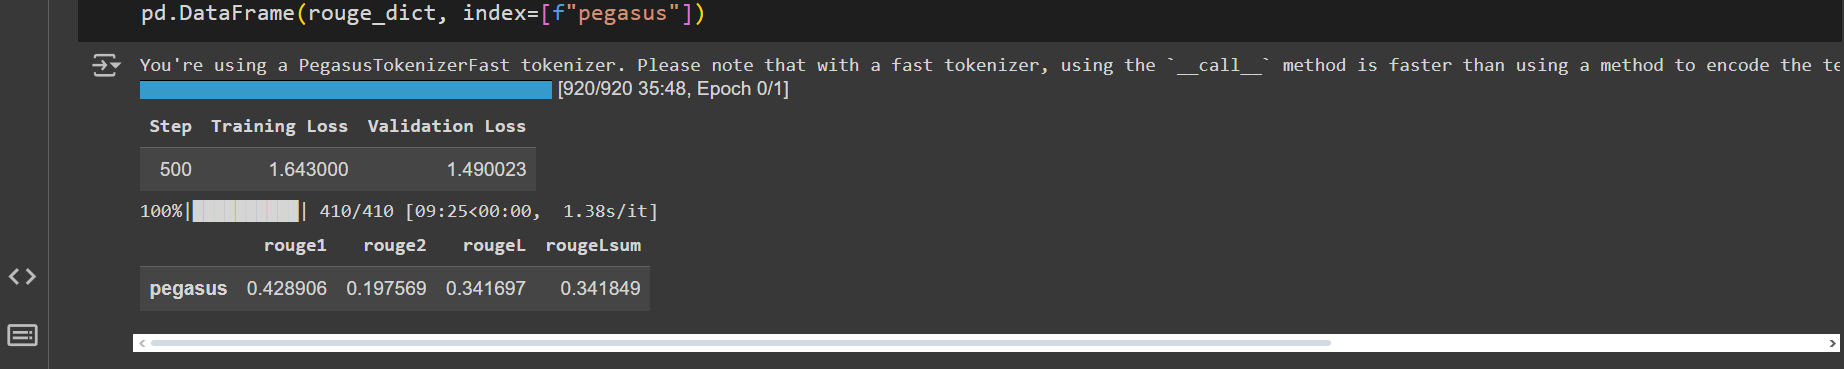

Hemos obtenido incluso mayores puntuajes, principalmente debido a que hemos usado un modelo más capacitado que PEGASUS.

Ejemplo usando el modelo entrenado en diálogos en inglés del capítulo 6:

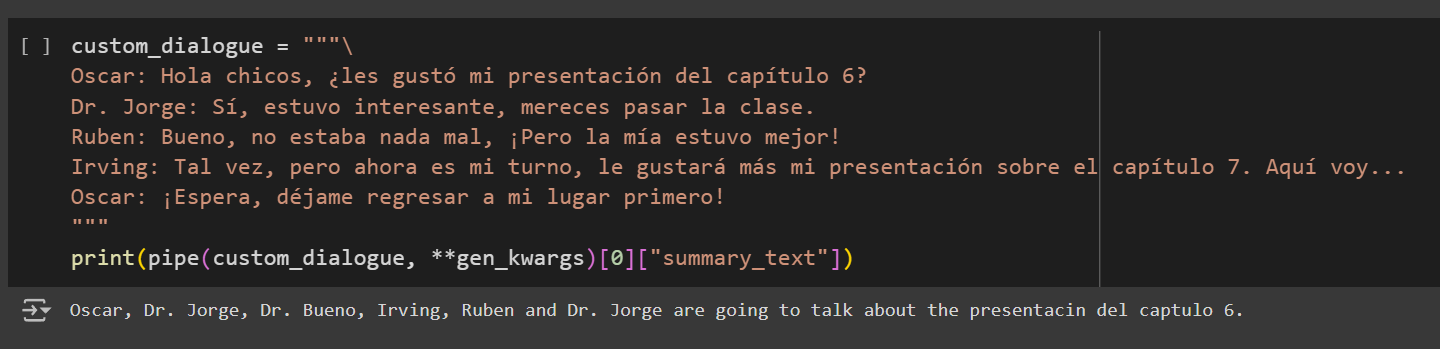

Nuestro modelo FLAN-T5 LARGE

In [35]:
custom_dialogue = """\
Oscar: Hola chicos, ¿les gustó mi presentación del capítulo 6?
Dr. Jorge: Sí, estuvo interesante, mereces pasar la clase.
Ruben: Bueno, no estaba nada mal, ¡Pero la mía estuvo mejor!
Irving: Tal vez, pero ahora es mi turno, le gustará más mi presentación sobre el capítulo 7. Aquí voy...
Oscar: ¡Espera, déjame regresar a mi lugar primero!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 160, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


Ruben y Irving le gustaron la presentación de Oscar sobre el captulo 6. Irving le gustará más la presentación sobre el captulo 7.


## Destilando un modelo más pequeño

Ahora usaremos este modelo para entrenar una versión del FLAN T5 más pequeña, la cual cuenta con 200 millones de parámetros, casi 4 veces más pequeño.

In [63]:
teacher = model

student_name = "google/flan-t5-base"

student = AutoModelForSeq2SeqLM.from_pretrained(student_name)
#tokenizer = AutoTokenizer.from_pretrained(student_name)

print(print_number_of_trainable_model_parameters(student))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


In [36]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":4, "max_length": 160}
sample_text = dataset_samsum["train"][0]["dialogue"]
reference = dataset_samsum["train"][0]["summary"]
pipe = pipeline("summarization", model=student, tokenizer=tokenizer)

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 160, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Dialogue:
Amanda: Horneé galletas. ¿Quieres algunas?
Jerry: ¡Claro!
Amanda: Te las llevaré mañana :-)

Reference Summary:
Amanda horneó galletas y le llevará algunas a Jerry mañana.

Model Summary:
Amanda and Jerry are talking about the galletas. Amanda wants to ask Jerry about them. Amanda will call Jerry tomorrow morning to pick them up.


Su rendimiento es medio bueno debido a que es un modelo agnóstico pero no está adaptado al idioma español, sino que genera resúmenes de diálogos en inglés.

In [37]:
from tqdm import tqdm

responses2 = []

for t in tqdm(test_inputs):
    resp = pipe(t, **gen_kwargs)[0]["summary_text"]
    responses2.append(resp)

100%|██████████| 736/736 [32:10<00:00,  2.62s/it]


In [42]:
rouge_metric.add(predictions=responses2, references=baselines)
score = rouge_metric.compute()
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
records.append(rouge_dict)
pd.DataFrame(records, index=["flan-t5-large", "flan-t5-base_RAW"])

,rouge1,rouge2,rougeL,rougeLsum
flan-t5-large,0.706679,0.363733,0.368926,0.368926
flan-t5-base_RAW,0.224293,0.027396,0.125868,0.125868


Evaluándolo en seco vemos que deja mucho que desear, lo cual es normal.

## Destilación

Ahora, procedemos a definir la función de destilación con la kullback-leibler revertida. Esta función está más optimizada para destilar modelos generativos.

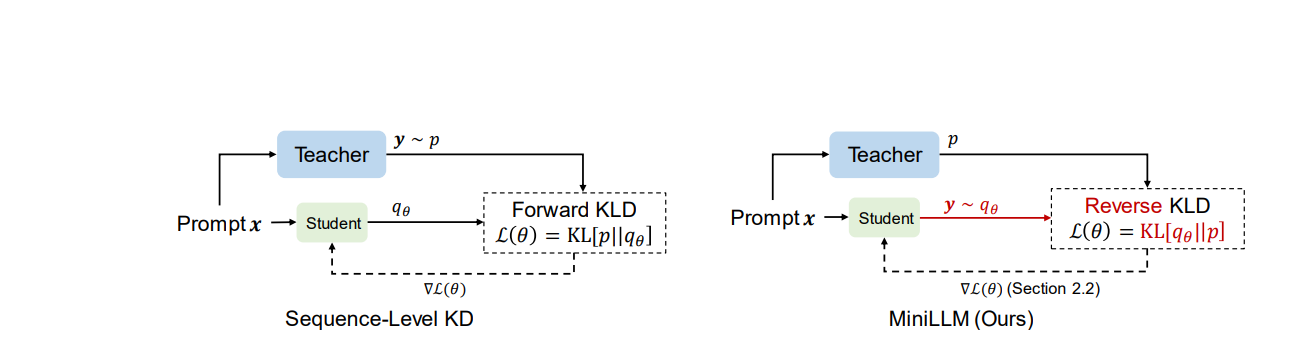

In [64]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)

        self.alpha = alpha
        self.temperature = temperature

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        self._move_model_to_device(self.teacher,self.model.device)
        self.teacher.eval()

    def compute_loss(self, model, inputs, return_outputs=False):

        # compute student output
        outputs_student = model(**inputs)
        student_loss=outputs_student.loss
        # compute teacher output
        with torch.no_grad():
          outputs_teacher = self.teacher(**inputs)

        assert outputs_student.logits.size() == outputs_teacher.logits.size()

        # Soften probabilities and compute distillation loss
        loss_function = nn.KLDivLoss(reduction="batchmean")
        loss_logits = (loss_function(
            F.log_softmax(outputs_teacher.logits / self.args.temperature, dim=-1),
            F.softmax(outputs_student.logits / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))

        loss = self.args.alpha * student_loss + (1. - self.args.alpha) * loss_logits
        return (loss, outputs_student) if return_outputs else loss

In [65]:
from huggingface_hub import notebook_login

notebook_login()

repo_name = "flan-t5-distilled_samsum"

Los hiperparámetros serían prácticamente los mismos pero con un learning rate más grande. Usaremos temperatura de 2 y un alpha de 0.5.

In [66]:
from transformers import TrainingArguments, Trainer
import time

training_args = DistillationTrainingArguments(
    output_dir=repo_name,
    learning_rate=5e-4,
    per_device_train_batch_size=1,
    gradient_accumulation_steps = 16,
    num_train_epochs=1,
    weight_decay=0.01,
    save_steps=1e6,
    logging_steps=1,
    use_cpu=False,
    push_to_hub=True,
    hub_model_id=repo_name,
    alpha=0.5,
    temperature=2.0
)

trainer = DistillationTrainer(
    student,
    training_args,
    teacher_model=teacher,
    tokenizer=tokenizer,
    data_collator=seq2seq_data_collator,
    train_dataset=dataset_samsum_pt["train"],
    eval_dataset=dataset_samsum_pt["valid"]
)

In [67]:
trainer.train()

Step,Training Loss
1,107.297900
2,68.117800
3,53.197700
4,59.306900
5,62.399400
6,56.671300
7,40.161100
8,37.099800
9,41.377200
10,54.475600


TrainOutput(global_step=827, training_loss=27.83403732295192, metrics={'train_runtime': 2875.4202, 'train_samples_per_second': 4.607, 'train_steps_per_second': 0.288, 'total_flos': 4445228070586368.0, 'train_loss': 27.83403732295192, 'epoch': 0.9988676681512796})

In [68]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":4, "max_length": 160}
sample_text = dataset_samsum["train"][0]["dialogue"]
reference = dataset_samsum["train"][0]["summary"]
pipe = pipeline("summarization", model=student, tokenizer=tokenizer)

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 160, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Dialogue:
Amanda: Horneé galletas. ¿Quieres algunas?
Jerry: ¡Claro!
Amanda: Te las llevaré mañana :-)

Reference Summary:
Amanda horneó galletas y le llevará algunas a Jerry mañana.

Model Summary:
Amanda llevará a Jerry maana a las galletas en el lugar de una reunión.


Observamos que los resultados son bastante buenos.

In [69]:
from tqdm import tqdm

responses3 = []

for t in tqdm(test_inputs):
    resp = pipe(t, **gen_kwargs)[0]["summary_text"]
    responses3.append(resp)

100%|██████████| 736/736 [14:46<00:00,  1.20s/it]


También podemos comparar el modelo estudiante, profesor y el ground truth.

In [71]:
zipped_summaries = list(zip(baselines, responses, responses3))
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'teacher_model_summaries', 'student_model_summaries'])
df.sample(n=5)

,human_baseline_summaries,teacher_model_summaries,student_model_summaries
57,Kelton estaba intentando descargar la película...,Kelton está tratando de descargar la pelcula q...,Kelton y Dalenna se encontrarán en un sitio di...
184,Papá quiere que Olaf baje las escaleras para c...,Papá está haciendo panqueques baja al piso de ...,El papá está haciendo unos panqueques en el pi...
403,Lloyd está preocupado por su mamá porque ella ...,Lloyd no puede comunicarse con mamá porque ell...,Lloyd está en casa y no puede encontrarse con ...
67,Luke está asombrado por Ghost. Simon no conoce...,Luke y Simon están encantados con Ghost.,Luke y Simon encontrarán el banda de Ghost y e...
220,Es difícil para Flo confiar en la gente a prim...,"Flo confa en Andy, pero hay algunas personas e...",Flo confa a Emma en el lugar de las personas e...


Y finalmente, podemos evaluar numéricamente los resultados, vemos que obtuvimos una increíble mejora a pesar de ser un modelo cuatro veces más pequeño.

In [72]:
rouge_metric.add(predictions=responses3, references=baselines)
score = rouge_metric.compute()
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
records.append(rouge_dict)
pd.DataFrame(records, index=["flan-t5-large", "flan-t5-base_RAW", "flan-t5-base_Distilled"])

,rouge1,rouge2,rougeL,rougeLsum
flan-t5-large,0.706679,0.363733,0.368926,0.368926
flan-t5-base_RAW,0.224293,0.027396,0.125868,0.125868
flan-t5-base_Distilled,0.650020,0.303378,0.307566,0.307566


Por último podemos usar nuestro clásico ejemplo personalizado.

In [73]:
custom_dialogue = """\
Oscar: Hola chicos, ¿les gustó mi presentación del capítulo 6?
Dr. Jorge: Sí, estuvo interesante, mereces pasar la clase.
Ruben: Bueno, no estaba nada mal, ¡Pero la mía estuvo mejor!
Irving: Tal vez, pero ahora es mi turno, le gustará más mi presentación sobre el capítulo 7. Aquí voy...
Oscar: ¡Espera, déjame regresar a mi lugar primero!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 160, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


Oscar le gustó su presentación de el captulo 7 y espera que regresará a su lugar.
